Heavy lift from https://botorch.org/tutorials/closed_loop_botorch_only

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from typing import Optional

import torch

from botorch.models.transforms.input import Normalize
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.objective import GenericMCObjective
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from sklearn.manifold import TSNE

from gpytorch.kernels import MaternKernel

import time
import warnings

from botorch import fit_gpytorch_mll
from botorch.acquisition import (
    qLogExpectedImprovement,
    qLogNoisyExpectedImprovement,
    qUpperConfidenceBound
)
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler

import json
import pandas as pd

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

import matplotlib.pyplot as plt

import sys
sys.path.append('/home/bgpelkie/Code/silica-np-synthesis/')
from sample_utilities import samples
import numpy as np

## Load existing data

In [3]:
with open('constants_2024_11_18.json', 'rt') as f:
    synth_constants = json.load(f) 

In [4]:
bounds = {}
for reactant, consts in synth_constants.items():
    bound = (consts['minimum_volume_fraction'], consts['maximum_volume_fraction'])
    bounds[reactant] = bound

In [5]:
synth_data = pd.read_csv('synth_table_ap_distance_11_16_24.csv')
synth_data = synth_data[~synth_data['ap_distance'].isna()]
#synth_data = synth_data[synth_data['ap_distance'] < 8]

In [6]:
synth_data

,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,dilution_volume_fraction,silica_mass_conc,silica_mass_fraction,ethanol_dilute_vol,sample_dilute_vol,dilute_well,target_volume,teos_vol_frac,ammonia_vol_frac,water_vol_frac,ethanol_vol_frac,ap_distance,experiment_status,rank
2,130093e4-2947-4d37-b73a-ed4c23442ab8,20.00000,64.000000,49.000000,1567.000000,0.903794,3.190814,0.003982,NaN,NaN,NaN,1700.0,0.011765,0.037647,0.028824,0.921765,0.904308,complete,9.0
3,a3f7d49b-cc77-4468-aae0-ad451027ddc0,181.00000,9.000000,228.000000,1283.000000,0.100743,28.625618,0.034357,NaN,NaN,NaN,1701.0,0.106408,0.005291,0.134039,0.754262,1.467659,complete,49.0
4,f69628da-ff56-4f3a-ba2e-816036b87557,100.00000,52.000000,15.000000,1534.000000,0.182971,15.761151,0.019630,NaN,NaN,NaN,1701.0,0.058789,0.030570,0.008818,0.901822,1.498439,complete,72.0
5,eb5c038c-56ff-4457-93db-9b9702e3ff43,211.00000,12.000000,61.000000,1415.000000,0.086378,33.386217,0.040940,NaN,NaN,NaN,1699.0,0.124191,0.007063,0.035903,0.832843,1.647393,complete,113.0
6,56898b1b-5aed-4595-ade6-5b73d45a7808,101.00000,100.000000,33.000000,1467.000000,0.180763,15.953695,0.019736,NaN,NaN,NaN,1701.0,0.059377,0.058789,0.019400,0.862434,1.708555,complete,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,7f042b90-a311-4af9-bb43-69e8c874b62c,17.00000,49.949998,92.868942,1540.181060,2.232143,2.691584,0.003342,0.0,1700.0,E8,1700.0,0.010000,0.029382,0.054629,0.905989,0.894470,complete,8.0
196,a53538a9-2e62-41df-ab0b-de034c8bd0aa,17.00000,21.387521,165.744269,1495.868210,2.232143,2.691584,0.003313,0.0,1700.0,F1,1700.0,0.010000,0.012581,0.097497,0.879922,0.907345,complete,10.0
197,1a084599-bbe6-4de7-89ef-9791617c5e9f,17.00000,26.973989,130.216619,1525.809392,2.232143,2.691584,0.003329,0.0,1700.0,F2,1700.0,0.010000,0.015867,0.076598,0.897535,0.953726,complete,13.0
198,d8a17275-4162-4633-bb9d-09d514ab7cb9,17.00000,33.144234,144.481243,1505.374523,2.232143,2.691584,0.003320,0.0,1700.0,F3,1700.0,0.010000,0.019497,0.084989,0.885514,0.916576,complete,11.0


In [7]:
x_data = synth_data[['teos_vol_frac', 'ammonia_vol_frac', 'water_vol_frac']]
y_data = - synth_data['ap_distance']

In [8]:
y_data.min()

np.float64(-2.466393911754304)

In [9]:
y_data = np.exp(y_data)

## data pre-processing

In [10]:
y_data_norm = normalize(torch.tensor(y_data.to_numpy()), torch.tensor([[y_data.min()], [y_data.max()]])).reshape(-1,1)

In [11]:
bounds_torch_norm = torch.tensor([bounds['TEOS'], bounds['ammonia'], bounds['water']]).transpose(-1, -2)

In [12]:
bounds_torch_opt = torch.tensor([[0, 0, 0], [1.0, 1.0, 1.0]], dtype = torch.float32)

In [13]:
x_data_torch = torch.tensor(x_data.to_numpy())

In [14]:
x_data_norm = normalize(x_data_torch, bounds_torch_norm)

## Visualize design space

In [15]:
## Concentrations

In [16]:
x_data_norm[:,0]

tensor([ 1.2605e-02,  6.8863e-01,  3.4849e-01,  8.1565e-01,  3.5269e-01,
         2.5210e-02,  9.2437e-02,  2.1849e-01,  8.4504e-03,  3.1070e-01,
         2.6471e-01,  1.9343e-01,  2.6050e-01,  6.7145e-02,  6.3104e-02,
         3.2353e-01,  7.5544e-02,  8.6500e-01,  5.5882e-01,  7.0123e-01,
         5.6723e-01,  1.9312e-01,  4.1988e-01,  2.8151e-01,  3.8655e-01,
         8.5714e-01,  3.0252e-01,  9.6738e-02,  1.6807e-01,  5.0806e-01,
         7.8571e-01,  6.7271e-01,  2.1445e-01,  1.6755e-02,  9.9222e-01,
         4.9160e-01,  4.6219e-01,  2.6754e-02,  9.0631e-02,  3.8195e-01,
         5.3007e-01,  5.4361e-01,  7.9045e-01,  2.1924e-01,  9.7736e-03,
         2.7761e-01,  3.1017e-01,  8.9481e-01,  2.6543e-01,  9.3022e-01,
         3.5177e-01,  1.9465e-01,  2.6124e-01,  8.2756e-01,  5.0021e-01,
         8.0085e-01,  6.5810e-02,  6.2584e-02,  2.5726e-01,  3.2338e-01,
         7.4829e-02,  8.6348e-01,  7.0816e-01,  5.5900e-01,  7.0063e-01,
         2.1551e-01,  5.6752e-01,  6.1768e-01,  5.1

In [17]:
best_10_ind = torch.argsort(y_data_norm, dim = 0, descending = True)[0:10].reshape(-1)

In [18]:
best_10_ind

tensor([  9,   8,  27,  81, 160,  33, 171, 175,   0, 176])

In [19]:
X_best10 = x_data_norm[best_10_ind,:]

In [20]:
X_best10.shape

torch.Size([10, 3])

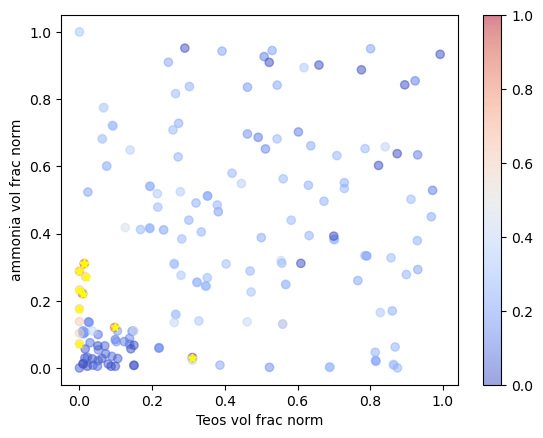

In [21]:
fig, ax = plt.subplots()

sc = ax.scatter(x_data_norm[:,0], x_data_norm[:,1], c = y_data_norm, cmap = plt.cm.coolwarm, alpha=0.5)
ax.set_xlabel('Teos vol frac norm')
ax.set_ylabel('ammonia vol frac norm')


ax.scatter(X_best10[:,0], X_best10[:,1], marker = '*', color = 'yellow')
cbar = fig.colorbar(sc, ax = ax)

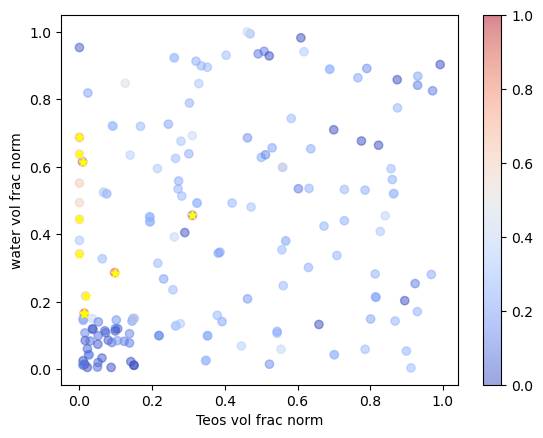

In [22]:
fig, ax = plt.subplots()

sc = ax.scatter(x_data_norm[:,0], x_data_norm[:,2], c = y_data_norm, cmap = plt.cm.coolwarm, alpha=0.5)
ax.set_xlabel('Teos vol frac norm')
ax.set_ylabel('water vol frac norm')


ax.scatter(X_best10[:,0], X_best10[:,2], marker = '*', color = 'yellow')
cbar = fig.colorbar(sc, ax = ax)

In [23]:
### TSNE rep

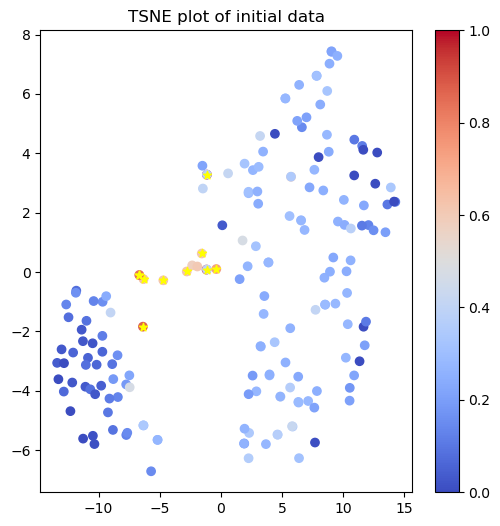

In [24]:

tsne = TSNE()

x_tsne_og = tsne.fit_transform(x_data_norm)

x_tsne_bestn = x_tsne_og[best_10_ind,:]

fig, ax = plt.subplots(figsize = (6,6))

sc = ax.scatter(x_tsne_og[:,0][:len(x_data_norm)], x_tsne_og[:,1][:len(x_data_norm)], c = y_data_norm, cmap = plt.cm.coolwarm)

ax.scatter(x_tsne_bestn[:,0], x_tsne_bestn[:,1], marker = '*', c = 'yellow')
ax.set_title("TSNE plot of initial data")
fig.colorbar(sc, ax = ax)

## Set up BO things

In [25]:
#bounds = torch.tensor([[0.0] * 3, [1.0] * 3], device=device, dtype=dtype)

BATCH_SIZE = 20  if not SMOKE_TEST else 2
NUM_RESTARTS = 50 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 32

N_TRIALS = 3 if not SMOKE_TEST else 2
N_BATCH = 20 if not SMOKE_TEST else 2
MC_SAMPLES = 512 if not SMOKE_TEST else 32

## kernal parameters
nu = 5/2
ard_num_dims = 3 # None to turn off

verbose = False

train_x = x_data_norm
train_y = y_data_norm

In [26]:
def initialize_model(train_x, train_y, state_dict=None, nu = 5/2, ard_num_dims = None):
    # define models for objective and constraint
    kernel = MaternKernel(nu = nu, ard_num_dims = 3)
    model_obj = SingleTaskGP(
        train_x,
        train_y,
        input_transform=Normalize(d=train_x.shape[-1]),
        covar_module=kernel
    ).to(train_x)

    # combine into a multi-output GP model
    mll = ExactMarginalLogLikelihood(model_obj.likelihood, model_obj)
    # load state dict if it is passed
    if state_dict is not None:
        model_obj.load_state_dict(state_dict)
    return mll, model_obj

In [27]:
def obj_callable(Z: torch.Tensor, X: Optional[torch.Tensor] = None):
    return Z[..., 0]



objective = GenericMCObjective(objective=obj_callable)

In [28]:
warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)




best_observed_all_ei, best_observed_all_nei, best_random_all = [], [], []

# average over multiple trials


best_observed_ei, best_observed_nei, best_random = [], [], []

# call helper functions to generate initial training data and initialize model

mll_nei, model_nei = initialize_model(train_x, train_y)

t0 = time.monotonic()

# fit the models

fit_gpytorch_mll(mll_nei)

# define the qEI and qNEI acquisition modules using a QMC sampler
qmc_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))

# for best_f, we use the best observed noisy values as an approximation


qLogNEI = qLogNoisyExpectedImprovement(
    model=model_nei,
    X_baseline=train_x,
    sampler=qmc_sampler,
    objective=objective,
    prune_baseline=True
)

#ucb = qUpperConfidenceBound(
#    model = model_nei, 
##    beta = 5,
#    sampler = qmc_sampler, 
#)

# optimize for new candidates
candidates, _ = optimize_acqf(
    acq_function=qLogNEI,
    bounds=bounds_torch_opt,
    q=BATCH_SIZE,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    #options={"batch_limit": 5, "maxiter": 200},
)




In [29]:
posterior = model_nei.posterior(train_x)
mean = posterior.mean.detach()

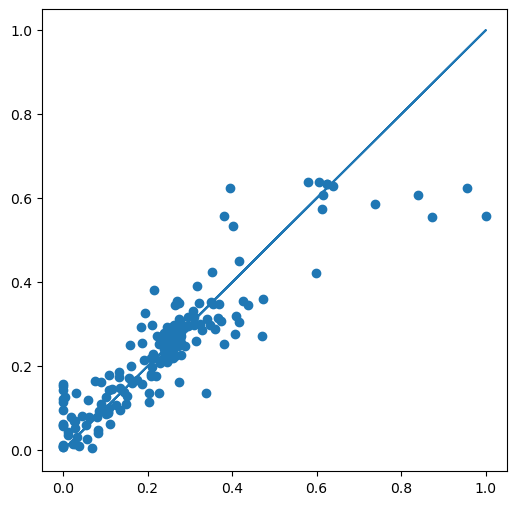

In [30]:
fig, ax = plt.subplots(figsize = (6,6))

ax.scatter(train_y, mean)
ax.plot(train_y, train_y)

(array([38., 27., 72., 21.,  9.,  2.,  6.,  1.,  2.,  2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

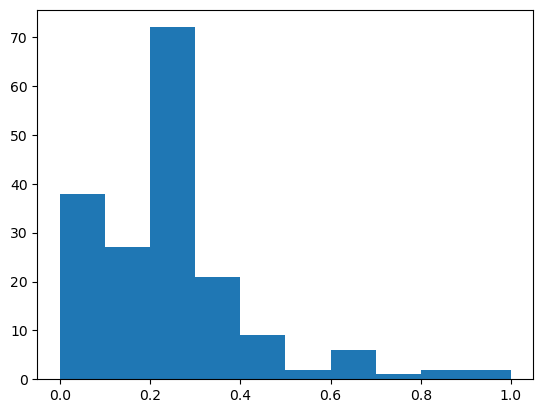

In [31]:
plt.hist(train_y)

In [32]:
train_x.max()

tensor(1.0000, dtype=torch.float64)

## Visualize model predictions

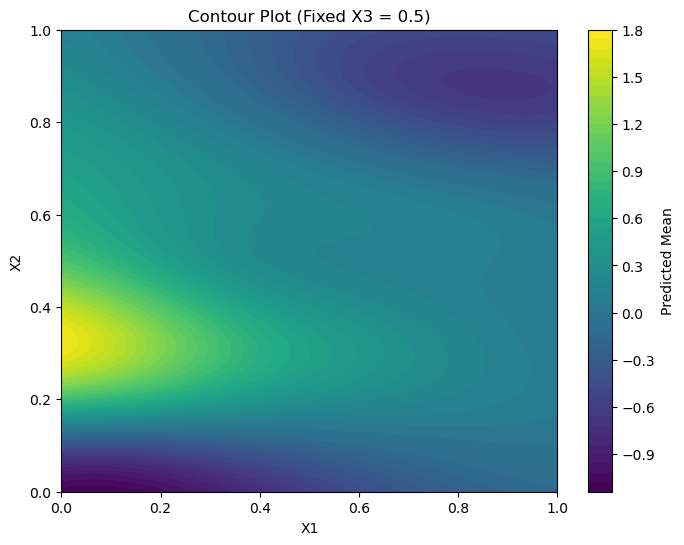

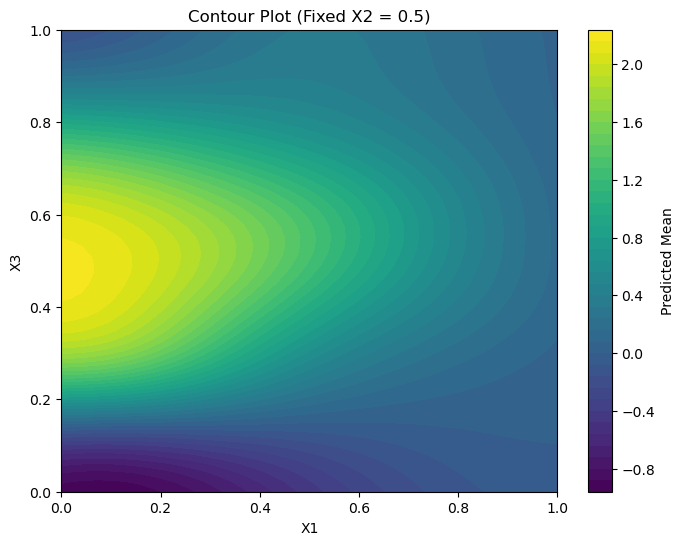

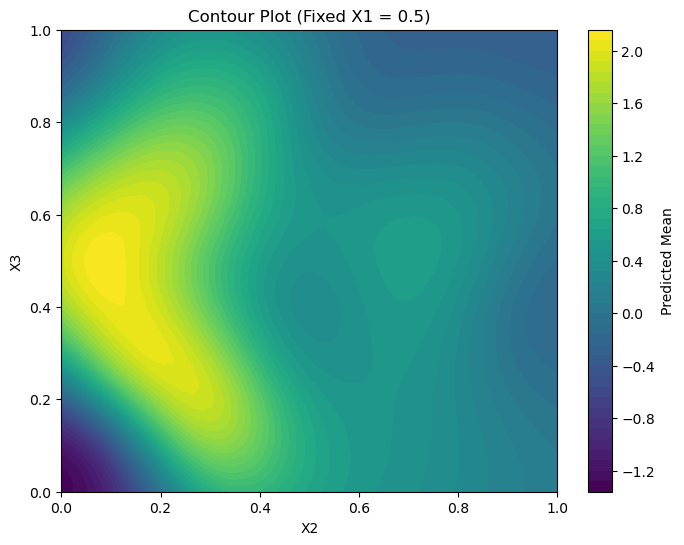

In [33]:
# Define a grid for each dimension
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)

# Helper function to create contour plots
def plot_contour_fixed_dimension(model, fixed_dim, fixed_val, x_range, y_range, dim_labels, title):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Predict with the model
    model.eval()
    with torch.no_grad():
        preds = model(grid_tensor)
        mean = preds.mean.numpy().reshape(X.shape)  # Reshape to match grid

    # Plot the contour
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, mean, levels=50, cmap="viridis")
    plt.colorbar(cp, label="Predicted Mean")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()

# Plot 2D contour slices by fixing each dimension at a particular value
fixed_vals = [0.1, 0.1, 0.1]  # Fix each dimension at the midpoint of its range

# Slice along X1 and X2, fixing X3 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=2, fixed_val=fixed_vals[2], 
                             x_range=x, y_range=y, 
                             dim_labels=["X1", "X2"], 
                             title="Contour Plot (Fixed X3 = 0.5)")


# Slice along X1 and X3, fixing X2 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=1, fixed_val=fixed_vals[1], 
                             x_range=x, y_range=z, 
                             dim_labels=["X1", "X3"], 
                             title="Contour Plot (Fixed X2 = 0.5)")

# Slice along X2 and X3, fixing X1 at 0.5
plot_contour_fixed_dimension(model_nei, fixed_dim=0, fixed_val=fixed_vals[0], 
                             x_range=y, y_range=z, 
                             dim_labels=["X2", "X3"], 
                             title="Contour Plot (Fixed X1 = 0.5)")


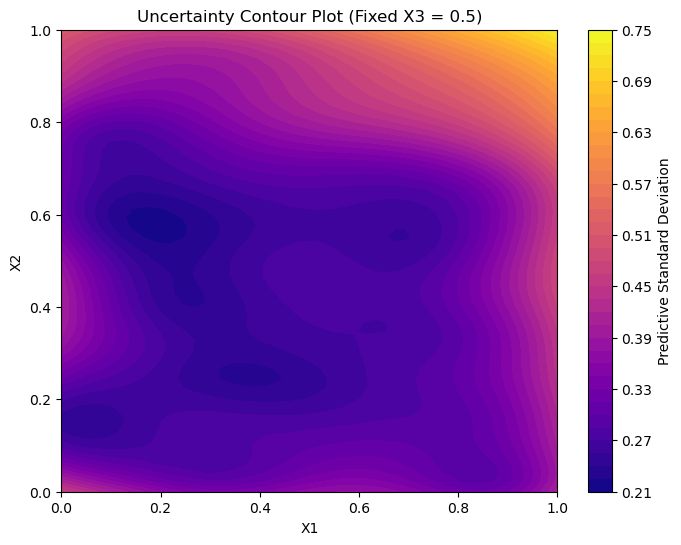

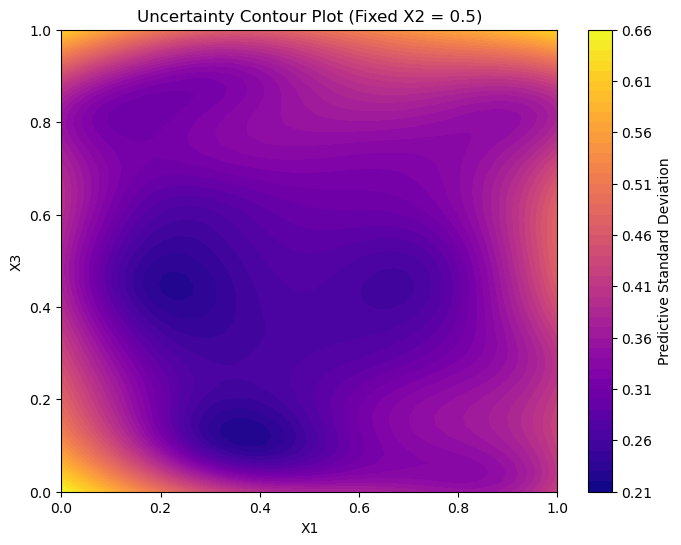

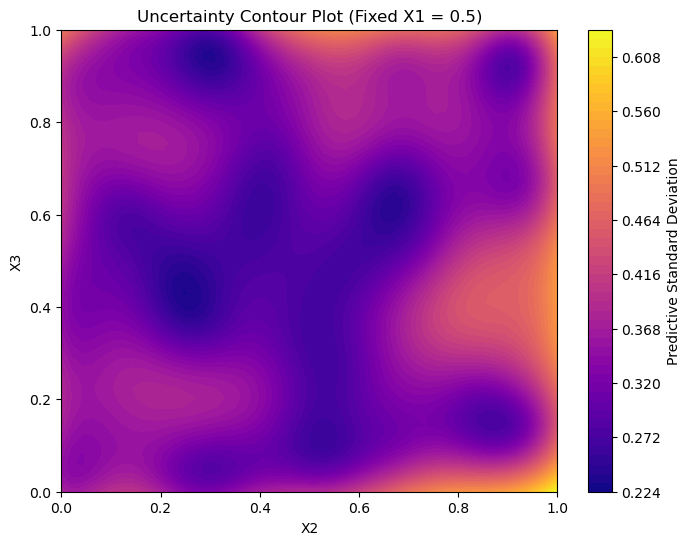

In [34]:
# Define a grid for each dimension
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)

# Helper function to create contour plots for uncertainty
def plot_contour_uncertainty(model, fixed_dim, fixed_val, x_range, y_range, dim_labels, title):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Predict with the model to get uncertainty (standard deviation)
    model.eval()
    with torch.no_grad():
        preds = model(grid_tensor)
        std_dev = preds.variance.sqrt().numpy().reshape(X.shape)  # Reshape to match grid

    # Plot the contour of uncertainty
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, std_dev, levels=50, cmap="plasma")  # Plasma color map for uncertainty
    plt.colorbar(cp, label="Predictive Standard Deviation")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()

# Plot 2D contour slices of uncertainty by fixing each dimension at a particular value
fixed_vals = [0.5, 0.5, 0.5]  # Fix each dimension at the midpoint of its range

# Slice along X1 and X2, fixing X3 at 0.5
plot_contour_uncertainty(model_nei, fixed_dim=2, fixed_val=fixed_vals[2], 
                         x_range=x, y_range=y, 
                         dim_labels=["X1", "X2"], 
                         title="Uncertainty Contour Plot (Fixed X3 = 0.5)")

# Slice along X1 and X3, fixing X2 at 0.5
plot_contour_uncertainty(model_nei, fixed_dim=1, fixed_val=fixed_vals[1], 
                         x_range=x, y_range=z, 
                         dim_labels=["X1", "X3"], 
                         title="Uncertainty Contour Plot (Fixed X2 = 0.5)")

# Slice along X2 and X3, fixing X1 at 0.5
plot_contour_uncertainty(model_nei, fixed_dim=0, fixed_val=fixed_vals[0], 
                         x_range=y, y_range=z, 
                         dim_labels=["X2", "X3"], 
                         title="Uncertainty Contour Plot (Fixed X1 = 0.5)")

## ACQ func value

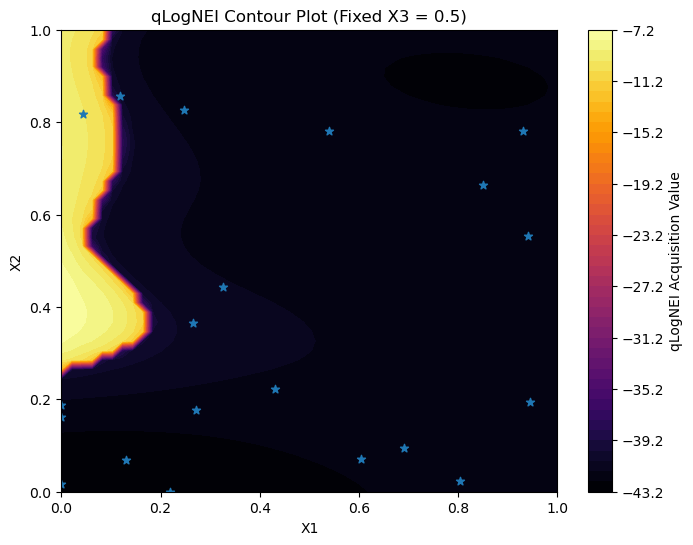

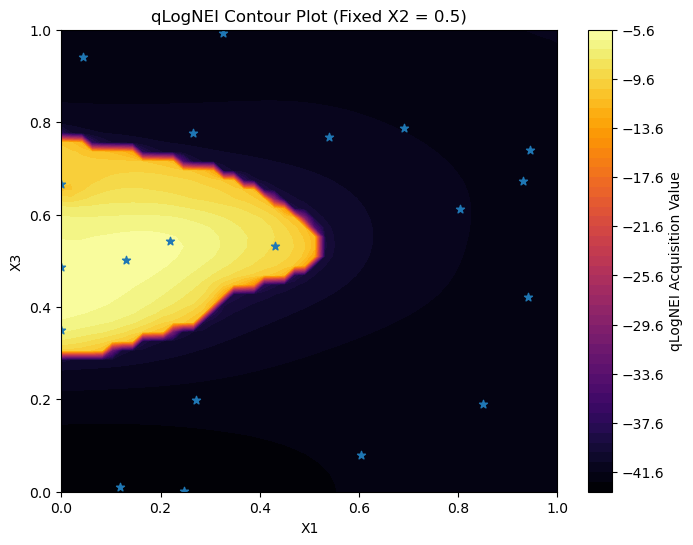

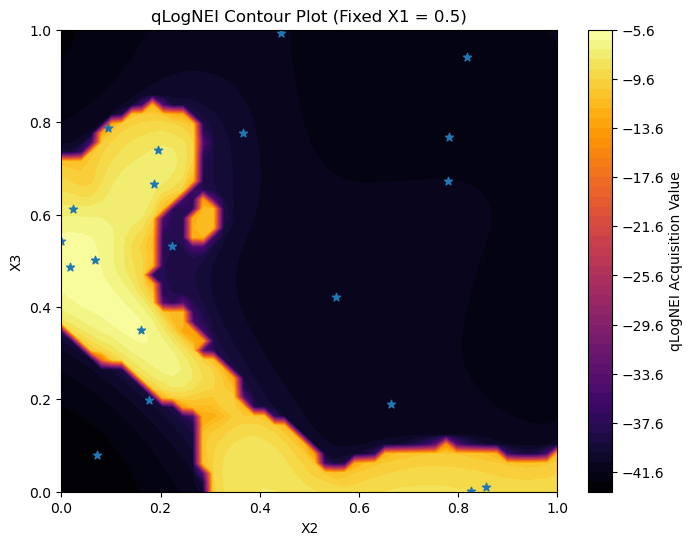

In [35]:
acq_func = qLogNEI
# Define a grid for each dimension
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
z = np.linspace(0, 1, 50)

# Helper function to create contour plots for qLogNoisyExpectedImprovement
def plot_qlognei_contour(acq_func, fixed_dim, fixed_val, x_range, y_range, dim_labels, title, candidates = candidates):
    X, Y = np.meshgrid(x_range, y_range)
    grid = np.zeros((X.size, 3))  # Initialize grid in 3D space
    grid[:, fixed_dim] = fixed_val  # Fix one dimension
    grid[:, [i for i in range(3) if i != fixed_dim]] = np.c_[X.ravel(), Y.ravel()]  # Set grid points for other 2 dims
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Compute qLogNoisyExpectedImprovement values at each grid point individually
    acq_func_values = []
    for i in range(grid_tensor.shape[0]):
        point = grid_tensor[i].unsqueeze(0)  # Make it a batch of 1
        acq_value = acq_func(point).item()  # Evaluate and get scalar value
        acq_func_values.append(acq_value)

    acq_func_values = np.array(acq_func_values).reshape(X.shape)  # Reshape to match grid

    dims = [0,1,2]
    dims.remove(fixed_dim)
    # Plot the contour of qLogNoisyExpectedImprovement
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, acq_func_values, levels=50, cmap="inferno")  # Inferno color map for acquisition function
    plt.scatter(candidates[:,dims[0]], candidates[:,dims[1]], marker = '*')
    plt.colorbar(cp, label="qLogNEI Acquisition Value")
    plt.xlabel(dim_labels[0])
    plt.ylabel(dim_labels[1])
    plt.title(title)
    plt.show()

# Plot 2D contour slices of qLogNEI by fixing each dimension at a particular value
fixed_vals = [0.06, 0.06, 0.06]  # Fix each dimension at the midpoint of its range

# Slice along X1 and X2, fixing X3 at 0.5
plot_qlognei_contour(acq_func, fixed_dim=2, fixed_val=fixed_vals[2], 
                     x_range=x, y_range=y, 
                     dim_labels=["X1", "X2"], 
                     title="qLogNEI Contour Plot (Fixed X3 = 0.5)", candidates =  candidates)

# Slice along X1 and X3, fixing X2 at 0.5
plot_qlognei_contour(acq_func, fixed_dim=1, fixed_val=fixed_vals[1], 
                     x_range=x, y_range=z, 
                     dim_labels=["X1", "X3"], 
                     title="qLogNEI Contour Plot (Fixed X2 = 0.5)", candidates = candidates)

# Slice along X2 and X3, fixing X1 at 0.5
plot_qlognei_contour(acq_func, fixed_dim=0, fixed_val=fixed_vals[0], 
                     x_range=y, y_range=z, 
                     dim_labels=["X2", "X3"], 
                     title="qLogNEI Contour Plot (Fixed X1 = 0.5)", candidates = candidates)


## Visualize new batch

In [36]:
tsne = TSNE()

In [37]:
x_data_norm.shape

torch.Size([180, 3])

In [38]:
all_x = torch.cat([x_data_norm, candidates])

In [39]:
x_tsne_og = tsne.fit_transform(all_x)

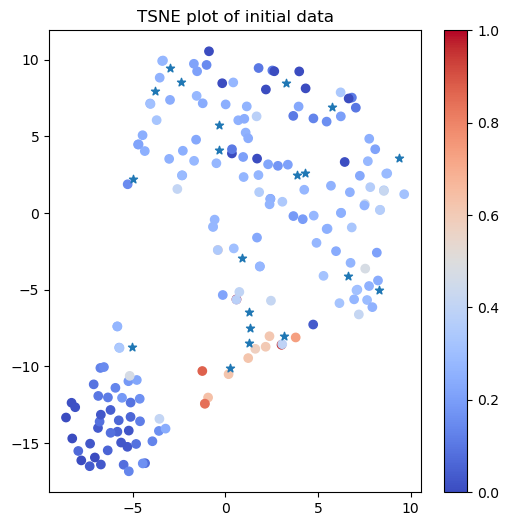

In [40]:
fig, ax = plt.subplots(figsize = (6,6))

sc = ax.scatter(x_tsne_og[:,0][:len(x_data_norm)], x_tsne_og[:,1][:len(x_data_norm)], c = train_y, cmap = plt.cm.coolwarm)
ax.scatter(x_tsne_og[:,0][len(x_data_norm):], x_tsne_og[:,1][len(x_data_norm):], marker='*')
ax.set_title("TSNE plot of initial data")
fig.colorbar(sc, ax = ax)

## Prep new sample table for next experiment

In [41]:
x_fractions = unnormalize(candidates, bounds_torch_norm)

In [42]:
target_volume = 1700
target_dilution = 0.1 # mol Si/L saxs sample
constants_fp = './constants_2024_11_18.json'
samples_write_fp = 'Sample_table_2024_11_18_optimizationRound4.csv'


In [43]:
samples_gen = []
for row in x_fractions:
    teos_vf = float(row[0])
    ammonia_vf = float(row[1])
    water_vf = float(row[2])

    sample = samples.SolidSilicaSample(target_volume, teos_vol_frac = teos_vf, ammonia_vol_frac=ammonia_vf, water_vol_frac=water_vf, reactant_fp = constants_fp)
    sample.calculate_reactant_volumes()
    sample.calculate_dilution_volumefraction(target_dilution)
    sample.calculate_silica_mass_concentration()
    sample.calculate_silica_mass_fraction()
    samples_gen.append(sample)

In [44]:
synth_table = samples.generate_synthesis_table(samples_gen)

In [45]:
synth_table['ethanol_dilute_vol'] = np.round(target_volume*(1-synth_table['dilution_volume_fraction']))
synth_table['sample_dilute_vol'] = np.round(target_volume * synth_table['dilution_volume_fraction'])

In [46]:
synth_table.loc[synth_table['ethanol_dilute_vol'] < 0, 'ethanol_dilute_vol'] = 0
synth_table.loc[synth_table['sample_dilute_vol'] > target_volume, 'sample_dilute_vol'] = target_volume

In [47]:
#assign rows to sample table
rows = ['A', 'B', 'C', 'D', 'E', 'F']
cols = [1, 2, 3, 4, 5, 6, 7, 8]

wells = []

#skip [B,E]x[2,7]
for row in rows:
    for col in cols:
        if row in ['B', 'E'] and col in [2, 7]:
            pass
        else:
            wells.append(row + str(col))

In [48]:
synth_table['well'] = wells[:len(synth_table)]


In [49]:
synth_table['dilute_well'] = wells[len(synth_table):2*len(synth_table)]

## Visualize new batch

In [50]:
synth_data['rank'] = synth_data['ap_distance'].rank()

In [51]:
best_row = synth_data.iloc[synth_data['ap_distance'].argmin()]

In [52]:
best10 = synth_data.iloc[synth_data['rank'].argsort().iloc[:10]]

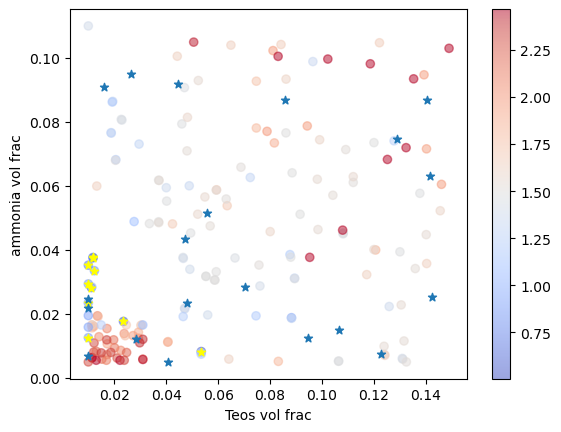

In [53]:
fig, ax = plt.subplots()

sc = ax.scatter(synth_data['teos_vol_frac'], synth_data['ammonia_vol_frac'], c = synth_data['ap_distance'], cmap = plt.cm.coolwarm, alpha=0.5)
ax.set_xlabel('Teos vol frac')
ax.set_ylabel('ammonia vol frac')


ax.scatter(best10['teos_vol_frac'], best10['ammonia_vol_frac'], marker = '*', color = 'yellow')
cbar = fig.colorbar(sc, ax = ax)

ax.scatter(synth_table['teos_volume']/1700, synth_table['ammonia_volume']/target_volume, marker = '*')

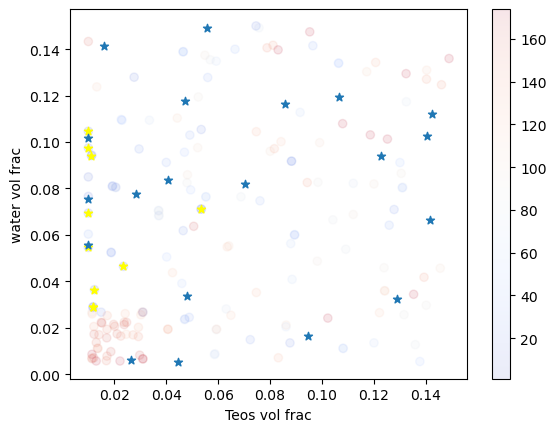

In [54]:
fig, ax = plt.subplots()

sc = ax.scatter(synth_data['teos_vol_frac'], synth_data['water_vol_frac'], c = synth_data['rank'], cmap = plt.cm.coolwarm, alpha=0.1)
ax.set_xlabel('Teos vol frac')
ax.set_ylabel('water vol frac')
cbar = fig.colorbar(sc, ax = ax)

ax.scatter(best10['teos_vol_frac'], best10['water_vol_frac'], marker = '*', color = 'yellow')

ax.scatter(synth_table['teos_volume']/1700, synth_table['water_volume']/target_volume, marker = '*')

In [55]:
synth_table

,uuid,teos_volume,ammonia_volume,water_volume,ethanol_volume,dilution_volume_fraction,silica_mass_conc,silica_mass_fraction,ethanol_dilute_vol,sample_dilute_vol,well,dilute_well
0,38f14a6c-5420-4923-9b2f-43a20ac7f20a,219.115850,127.092173,55.457296,1298.334681,0.173180,34.692277,0.042155,1406.0,294.0,A1,C7
1,4e26b40e-7222-4e64-84e2-6a82f66ec34a,94.716872,87.462098,253.290609,1264.530422,0.400630,14.996377,0.017977,1019.0,681.0,A2,C8
2,d8565d6c-c513-4555-b4e2-b2727ba8fa24,241.942695,43.193790,190.707941,1224.155574,0.156841,38.306417,0.045817,1433.0,267.0,A3,D1
3,3daae622-36a1-4778-8724-d5f78ffa207f,17.000000,37.308323,94.607152,1551.084525,2.232143,2.691584,0.003344,0.0,1700.0,A4,D2
4,326325ae-8faf-4b3c-bc9f-85b59b77813a,17.000000,41.996923,172.792853,1468.210224,2.232143,2.691584,0.003304,0.0,1700.0,A5,D3
5,c2119a39-013d-4c4e-bbcb-aad1badf902b,80.245513,73.877232,199.939331,1345.937925,0.472879,12.705149,0.015391,896.0,804.0,A6,D4
6,37470fe6-21f0-4663-b4c7-478a6501526f,240.782465,107.302607,112.585995,1239.328933,0.157596,38.122719,0.045901,1432.0,268.0,A7,D5
7,48f20022-58ba-407b-a8e2-9ee207737c07,181.423292,25.306854,202.683404,1290.586450,0.209160,28.724472,0.034556,1344.0,356.0,A8,D6
8,0f2f7161-744e-497e-80b9-b7c78eb36787,27.467893,154.563002,240.256497,1277.712608,1.381483,4.348950,0.005232,0.0,1700.0,B1,D7
9,cf752e09-3aef-4590-857f-a51ac610f227,145.550455,147.813044,197.524763,1209.111738,0.260710,23.044781,0.027580,1257.0,443.0,B3,D8


In [56]:
synth_table.to_csv('SampleTable_2024_11_18_OptimizationRound4.csv')